1. Analyzing UN General Assemby Voting patterns

In [1]:
import torch
from torch import nn
import numpy as np
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
import pandas as pd
import ast
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import networkx as nx
from node2vec import Node2Vec
import itertools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the UN Dataset

In [2]:
resolutions = load_dataset("sam-bha/un-general-assembly-votes-2000-2023", split="train")
print(resolutions)
print(resolutions['Title'])
print(resolutions['Agenda'])

Dataset({
    features: ['id', 'Title', 'Agenda', 'Resolution', 'Meeting record', 'Draft resolution', 'Note', 'Vote summary', 'Vote date', 'Vote', 'Collections', 'Committee report'],
    num_rows: 1796
})
['Cooperation between the United Nations and the Organisation for the Prohibition of Chemical Weapons : resolution / adopted by the General Assembly', 'Principles of the Charter of the United Nations underlying a comprehensive, just and lasting peace in Ukraine : resolution / adopted by the General Assembly', 'Cooperation between the United Nations and the Council of Europe : resolution / adopted by the General Assembly', 'Independent Institution on Missing Persons in the Syrian Arab Republic : resolution / adopted by the General Assembly', 'Financing of the United Nations Interim Force in Lebanon : resolution / adopted by the General Assembly', 'Status of internally displaced persons and refugees from Abkhazia, Georgia, and the Tskhinvali region/South Ossetia, Georgia : resolution / 

In [3]:
df = pd.DataFrame(resolutions)

# Inspecting the raw string format of the first few entries in the 'Vote' column
raw_vote_samples = df['Vote'].head(5)
raw_vote_samples.tolist()

[{'AFGHANISTAN': '',
  'ALBANIA': 'Y',
  'ALGERIA': 'A',
  'ANDORRA': 'Y',
  'ANGOLA': 'Y',
  'ANTIGUA AND BARBUDA': '',
  'ARGENTINA': 'Y',
  'ARMENIA': '',
  'AUSTRALIA': 'Y',
  'AUSTRIA': 'Y',
  'AZERBAIJAN': '',
  'BAHAMAS': '',
  'BAHRAIN': 'Y',
  'BANGLADESH': 'Y',
  'BARBADOS': '',
  'BELARUS': 'N',
  'BELGIUM': 'Y',
  'BELIZE': '',
  'BENIN': '',
  'BHUTAN': 'Y',
  'BOLIVIA': 'A',
  'BOSNIA AND HERZEGOVINA': 'Y',
  'BOTSWANA': 'Y',
  'BRAZIL': 'Y',
  'BRUNEI DARUSSALAM': 'Y',
  'BULGARIA': 'Y',
  'BURKINA FASO': '',
  'BURUNDI': 'A',
  'CABO VERDE': '',
  'CAMBODIA': 'A',
  'CAMEROON': '',
  'CANADA': 'Y',
  'CENTRAL AFRICAN REPUBLIC': '',
  'CHAD': 'Y',
  'CHILE': 'Y',
  'CHINA': 'N',
  'COLOMBIA': 'Y',
  'COMOROS': '',
  'CONGO': '',
  'COSTA RICA': 'Y',
  'CROATIA': 'Y',
  'CUBA': 'A',
  'CYPRUS': 'Y',
  'CZECHIA': 'Y',
  "CÔTE D'IVOIRE": 'Y',
  "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": '',
  'DEMOCRATIC REPUBLIC OF THE CONGO': '',
  'DENMARK': 'Y',
  'DJIBOUTI': 'Y',
  'DOMI

C:\Users\patfernandes\AppData\Local\Temp\ipykernel_8348\4273703393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=resolutions_per_year.index, y=resolutions_per_year.values, palette="viridis")


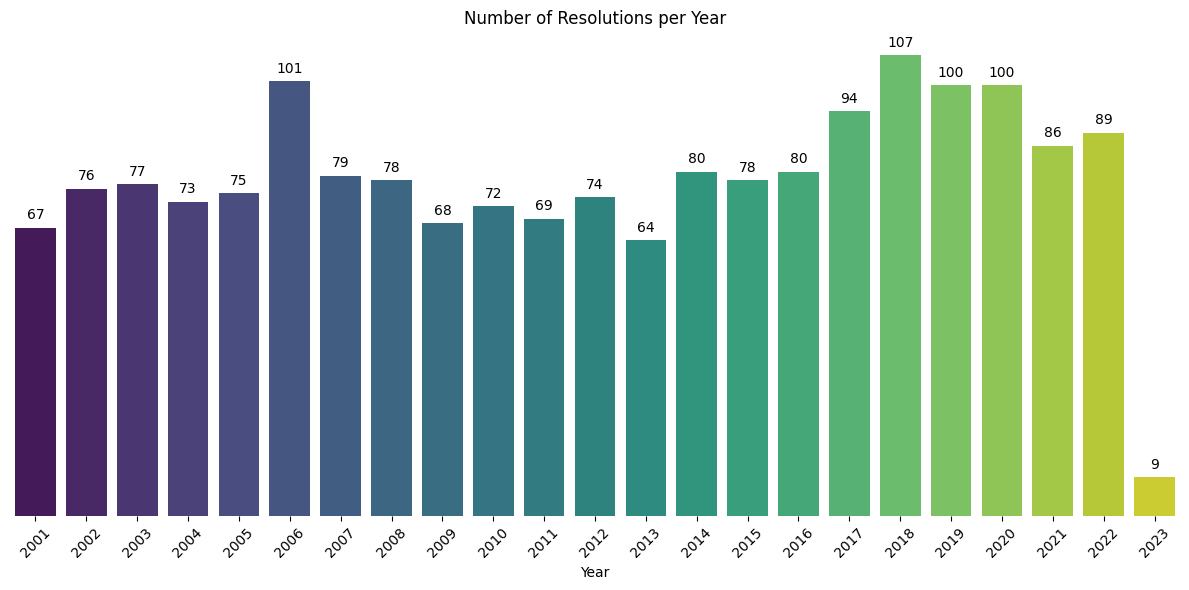

In [4]:
# Converting 'Vote date' to datetime
df['Vote date'] = pd.to_datetime(df['Vote date'])

# Extracting year from 'Vote date'
df['Year'] = df['Vote date'].dt.year

# Counting the number of resolutions per year
resolutions_per_year = df.groupby('Year').size()

# Plotting
plt.figure(figsize=(12, 6))
plot = sns.barplot(x=resolutions_per_year.index, y=resolutions_per_year.values, palette="viridis")

# Adding the number of resolutions on each bar
for p in plot.patches:
    plot.annotate(f"{int(p.get_height())}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')

plt.title('Number of Resolutions per Year')
plt.xlabel('Year')
plt.ylabel('')  # Removing y-axis label
plt.yticks([])  # Removing y-axis scale
plt.box(False)  # Removing the chart border line
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [5]:
def robust_parse_vote(vote_entry):
    # If the entry is already a dictionary, return it as-is
    if isinstance(vote_entry, dict):
        return vote_entry
    # If the entry is a string, attempt to parse it
    elif isinstance(vote_entry, str):
        try:
            # Using ast.literal_eval for safe evaluation
            vote_dict = ast.literal_eval(vote_entry)
            return vote_dict
        except:
            # If parsing fails, return an empty dictionary
            return {}
    # If the entry is neither a string nor a dictionary, return an empty dictionary
    else:
        return {}

# Apply the parsing function to the 'Vote' column
df['Parsed Vote'] = df['Vote'].apply(robust_parse_vote)

raw_vote_samples = df['Parsed Vote'].head(5)
raw_vote_samples.tolist()

[{'AFGHANISTAN': '',
  'ALBANIA': 'Y',
  'ALGERIA': 'A',
  'ANDORRA': 'Y',
  'ANGOLA': 'Y',
  'ANTIGUA AND BARBUDA': '',
  'ARGENTINA': 'Y',
  'ARMENIA': '',
  'AUSTRALIA': 'Y',
  'AUSTRIA': 'Y',
  'AZERBAIJAN': '',
  'BAHAMAS': '',
  'BAHRAIN': 'Y',
  'BANGLADESH': 'Y',
  'BARBADOS': '',
  'BELARUS': 'N',
  'BELGIUM': 'Y',
  'BELIZE': '',
  'BENIN': '',
  'BHUTAN': 'Y',
  'BOLIVIA': 'A',
  'BOSNIA AND HERZEGOVINA': 'Y',
  'BOTSWANA': 'Y',
  'BRAZIL': 'Y',
  'BRUNEI DARUSSALAM': 'Y',
  'BULGARIA': 'Y',
  'BURKINA FASO': '',
  'BURUNDI': 'A',
  'CABO VERDE': '',
  'CAMBODIA': 'A',
  'CAMEROON': '',
  'CANADA': 'Y',
  'CENTRAL AFRICAN REPUBLIC': '',
  'CHAD': 'Y',
  'CHILE': 'Y',
  'CHINA': 'N',
  'COLOMBIA': 'Y',
  'COMOROS': '',
  'CONGO': '',
  'COSTA RICA': 'Y',
  'CROATIA': 'Y',
  'CUBA': 'A',
  'CYPRUS': 'Y',
  'CZECHIA': 'Y',
  "CÔTE D'IVOIRE": 'Y',
  "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": '',
  'DEMOCRATIC REPUBLIC OF THE CONGO': '',
  'DENMARK': 'Y',
  'DJIBOUTI': 'Y',
  'DOMI

In [6]:
# Calculate the Yes vote ratio for each country
vote_counts = {}

for vote_dict in df['Parsed Vote']:
    for country, vote in vote_dict.items():
        if country not in vote_counts:
            vote_counts[country] = {'Yes': 0, 'Total': 0}
        if vote:
            vote_counts[country]['Total'] += 1
            if vote == 'Y':
                vote_counts[country]['Yes'] += 1

# Calculating the Yes vote ratio for each country
yes_vote_ratio = {country: (counts['Yes'] / counts['Total']) if counts['Total'] > 0 else 0 
                  for country, counts in vote_counts.items()}

# Convert the result to a DataFrame for better display
yes_vote_ratio_df = pd.DataFrame(list(yes_vote_ratio.items()), columns=['Country', 'Yes Vote Ratio'])

yes_vote_ratio_df

Country  Yes Vote Ratio
0    AFGHANISTAN        0.966004
1        ALBANIA        0.610691
2        ALGERIA        0.899385
3        ANDORRA        0.658824
4         ANGOLA        0.919562
..           ...             ...
187      VANUATU        0.784178
188    VENEZUELA        0.889354
189     VIET NAM        0.905233
190        YEMEN        0.921445
191       ZAMBIA        0.924484

[192 rows x 2 columns]

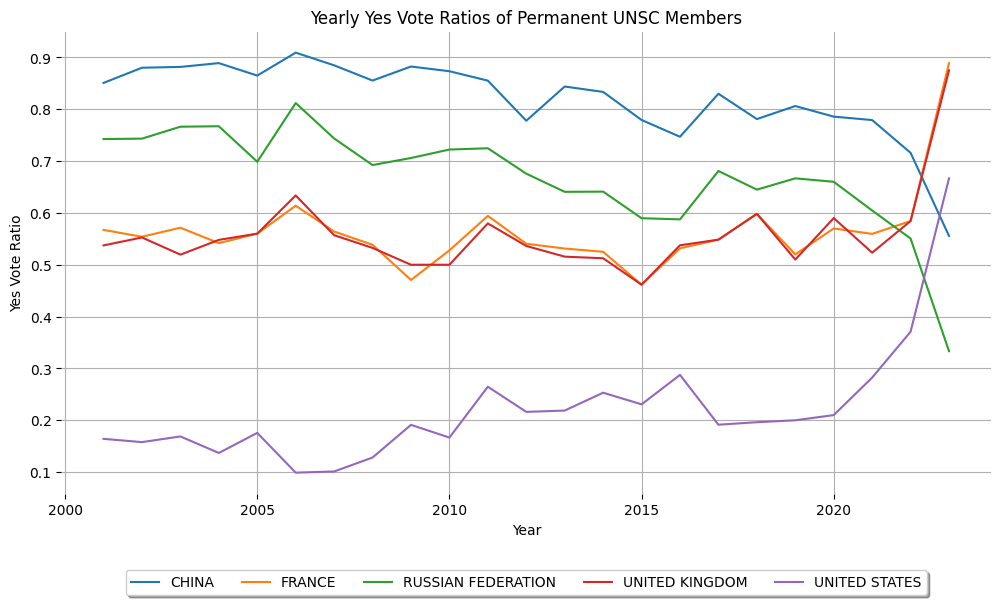

In [7]:
# Convert 'Vote date' to datetime and extract the year
df['Vote date'] = pd.to_datetime(df['Vote date'])
df['Year'] = df['Vote date'].dt.year

# Apply the robust parsing function to the 'Vote' column
df['Parsed Vote'] = df['Vote'].apply(robust_parse_vote)

# Permanent members of the United Nations Security Council
permanent_members = ['CHINA', 'FRANCE', 'RUSSIAN FEDERATION', 'UNITED KINGDOM', 'UNITED STATES']

# Initialize a dictionary to store the count of 'Yes' votes and total votes for each country and each year
yearly_vote_counts = {country: {year: {'Yes': 0, 'Total': 0} for year in df['Year'].unique()} for country in permanent_members}

# Iterate over the dataset to count the votes
for _, row in df.iterrows():
    year = row['Year']
    for country, vote in row['Parsed Vote'].items():
        if country in permanent_members:
            if vote:  # Counting only non-empty votes
                yearly_vote_counts[country][year]['Total'] += 1
                if vote == 'Y':
                    yearly_vote_counts[country][year]['Yes'] += 1

# Calculating the Yes vote ratio for each country and each year
yearly_yes_ratios = {country: {year: counts['Yes'] / counts['Total'] if counts['Total'] > 0 else 0 
                               for year, counts in years.items()} 
                     for country, years in yearly_vote_counts.items()}

# Converting the yearly ratios to a DataFrame for plotting
df_ratios = pd.DataFrame(yearly_yes_ratios)

# Plotting
plt.figure(figsize=(12, 6))
for country in permanent_members:
    plt.plot(df_ratios.index, df_ratios[country], label=country)

plt.title('Yearly Yes Vote Ratios of Permanent UNSC Members')
plt.xlabel('Year')
plt.ylabel('Yes Vote Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
plt.box(False)  # Removing the chart border line
plt.grid(True)
plt.show()


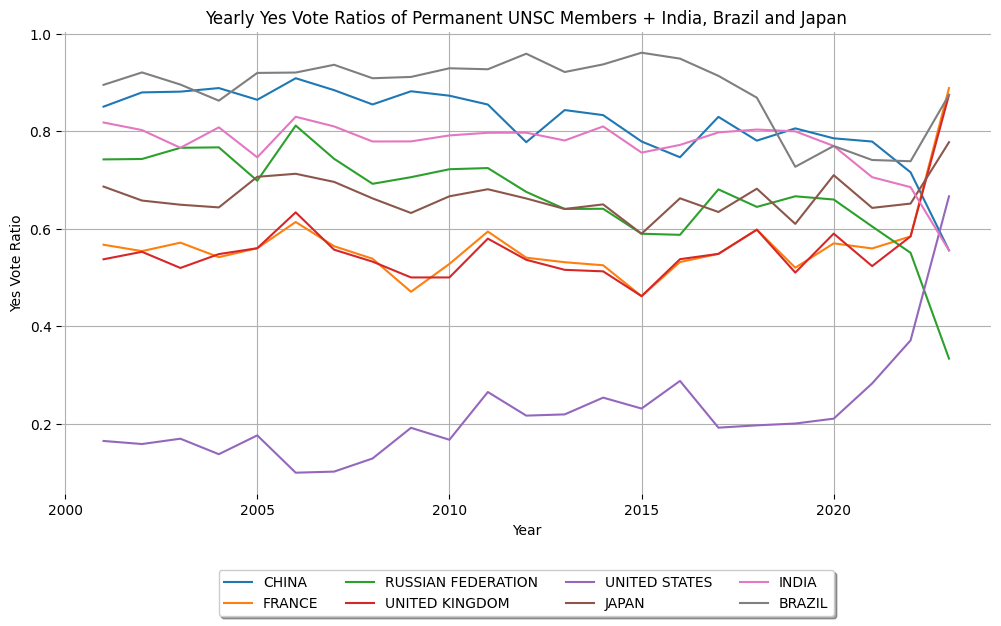

In [8]:
# Convert 'Vote date' to datetime and extract the year
df['Vote date'] = pd.to_datetime(df['Vote date'])
df['Year'] = df['Vote date'].dt.year

# Apply the robust parsing function to the 'Vote' column
df['Parsed Vote'] = df['Vote'].apply(robust_parse_vote)

# Permanent members of the United Nations Security Council + India, Brazil and Japan
permanent_members = ['CHINA', 'FRANCE', 'RUSSIAN FEDERATION', 'UNITED KINGDOM', 'UNITED STATES', 'JAPAN', 'INDIA', 'BRAZIL']

# Initialize a dictionary to store the count of 'Yes' votes and total votes for each country and each year
yearly_vote_counts = {country: {year: {'Yes': 0, 'Total': 0} for year in df['Year'].unique()} for country in permanent_members}

# Iterate over the dataset to count the votes
for _, row in df.iterrows():
    year = row['Year']
    for country, vote in row['Parsed Vote'].items():
        if country in permanent_members:
            if vote:  # Counting only non-empty votes
                yearly_vote_counts[country][year]['Total'] += 1
                if vote == 'Y':
                    yearly_vote_counts[country][year]['Yes'] += 1

# Calculating the Yes vote ratio for each country and each year
yearly_yes_ratios = {country: {year: counts['Yes'] / counts['Total'] if counts['Total'] > 0 else 0 
                               for year, counts in years.items()} 
                     for country, years in yearly_vote_counts.items()}

# Converting the yearly ratios to a DataFrame for plotting
df_ratios = pd.DataFrame(yearly_yes_ratios)

# Plotting
plt.figure(figsize=(12, 6))
for country in permanent_members:
    plt.plot(df_ratios.index, df_ratios[country], label=country)

plt.title('Yearly Yes Vote Ratios of Permanent UNSC Members + India, Brazil and Japan')
plt.xlabel('Year')
plt.ylabel('Yes Vote Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4)
plt.grid(True)
plt.box(False)  # Removing the chart border line
plt.show()

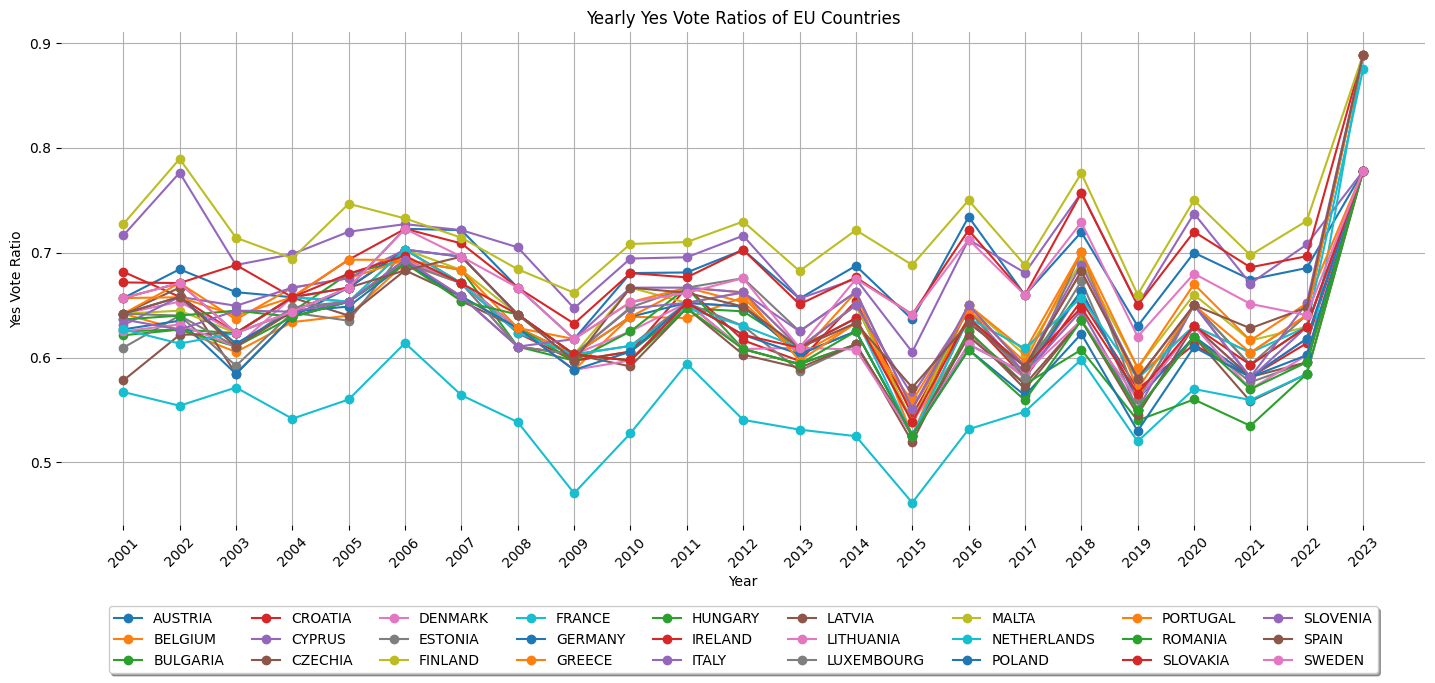

In [9]:
# EU members
eu_members = ["AUSTRIA", "BELGIUM", "BULGARIA", "CROATIA", "CYPRUS", "CZECHIA", "DENMARK", 
                  "ESTONIA", "FINLAND", "FRANCE", "GERMANY", "GREECE", "HUNGARY", "IRELAND", "ITALY",
                  "LATVIA", "LITHUANIA", "LUXEMBOURG", "MALTA", "NETHERLANDS", "POLAND", "PORTUGAL", 
                  "ROMANIA", "SLOVAKIA", "SLOVENIA", "SPAIN", "SWEDEN"]

# Initialize a dictionary to store the count of 'Yes' votes and total votes for each country and each year
yearly_vote_counts = {country: {year: {'Yes': 0, 'Total': 0} for year in df['Year'].unique()} for country in eu_members}

# Iterate over the dataset to count the votes
for _, row in df.iterrows():
    year = row['Year']
    for country, vote in row['Parsed Vote'].items():
        if country in eu_members:
            if vote:  # Counting only non-empty votes
                yearly_vote_counts[country][year]['Total'] += 1
                if vote == 'Y':
                    yearly_vote_counts[country][year]['Yes'] += 1

# Calculating the Yes vote ratio for each country and each year
yearly_yes_ratios = {country: {year: counts['Yes'] / counts['Total'] if counts['Total'] > 0 else 0 
                               for year, counts in years.items()} 
                     for country, years in yearly_vote_counts.items()}

# Converting the yearly ratios to a DataFrame for plotting
df_ratios = pd.DataFrame(yearly_yes_ratios)

# Plotting with horizontal legend below the graph
plt.figure(figsize=(15, 7))
for country in eu_members:
    plt.plot(df_ratios.index, df_ratios[country], label=country, marker='o')

plt.title('Yearly Yes Vote Ratios of EU Countries')
plt.xlabel('Year')
plt.ylabel('Yes Vote Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=9)
plt.grid(True)
plt.xticks(df_ratios.index, rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.box(False)  # Removing the chart border line
plt.show()

2. Embedding Model

we format the dataset, which converts the Y and N votes to pytorch tensors, with Y being 1, N being -1 and absence or abstention A being 0. When two countries vote the same way, their cross-correlation becomes 1. If they vote opposite one another, it becomes -1, and if one abstains or is absent, it becomes 0

In [10]:
class UNGAVotesDataSet(torch.utils.data.Dataset):
    def __init__(self, resolutions):
        super(UNGAVotesDataSet, self).__init__()

        self.resolutions = resolutions

        self.countries = {}

        for resolution in resolutions:
            for country, vote in  resolution['Vote'].items():
                if(not country in self.countries):
                    self.countries[country] = True

        self.votes  = []

        self.country_idx = []

        self.vote_correlations = []

        self.idx_by_country = {}

        self.num_countries  = len(self.countries)

        self.country_by_idx = [None]*self.num_countries

        for resolution in resolutions:

            votes_in_resolution = [0] * len(self.countries)
            country_indices = [0] * len(self.countries)

            for i, (country,_) in enumerate(self.countries.items()):
                vote = resolution['Vote'][country]

                if(vote == 'Y'):
                    votes_in_resolution[i] = 1

                if(vote == 'N'):
                    votes_in_resolution[i] = -1

                country_indices[i] = i

                if(self.country_by_idx[i] == None):
                    self.country_by_idx[i] = country

                if(not country in self.idx_by_country):
                    self.idx_by_country[country] = i

            self.country_idx.append(torch.tensor(country_indices))

            votes_in_resolution = torch.tensor(votes_in_resolution)

            self.votes.append(votes_in_resolution)

            vote_correlation = votes_in_resolution.unsqueeze(0).T * votes_in_resolution.unsqueeze(0)

            self.vote_correlations.append(vote_correlation)

    def __getitem__(self, idx):
        return self.country_idx[idx], self.vote_correlations[idx]

    def __len__(self):
        return len(self.country_idx)

In [11]:
dataset = UNGAVotesDataSet(resolutions)

In [12]:
# Create a data loader.
train_iter = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
class CountryEmbeddingModel(nn.Module):
    def __init__(self, num_countries=196, embedding_dim=32):
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=num_countries, embedding_dim=embedding_dim)

    def forward(self, X):
        a = self.embed(X)
        dot_product = torch.bmm(a, a.permute(0, 2,1))
        return dot_product

In [15]:
model = CountryEmbeddingModel(num_countries=dataset.num_countries, embedding_dim=32)

3. Training the model
We then use a loss function, so that the model can learn from the existing dataset (observations), and adjust the embeddings to minimize the difference between predictions of voting behavior and observed voting behavior.

In [16]:
class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse  = nn.MSELoss(reduction="mean")

    def forward(self, Y_hat, Y):

        Y_hat = Y_hat.reshape(Y_hat.shape[0], -1).float()
        Y = Y.reshape(Y.shape[0], -1).float()
        out = self.mse(Y_hat, Y)
        return out

In [17]:
loss = MSELoss()

We create a simple training loop to train the embedding model. 

In [18]:
def train_model(model, loss, data_loader, epochs, learning_rate):

    optimizer = torch.optim.Adam(model.parameters(),  lr=learning_rate)

    device = torch.device('cuda:0') if(torch.cuda.is_available()) else torch.device('cpu')

    model.to(device)

    for epoch in range(epochs):

        model.to(device)

        model.train()

        for i, (X, Y) in enumerate(tqdm(data_loader)):

            X = X.to(device)

            Y = Y.to(device)

            Y_hat = model(X)

            l = loss(Y_hat, Y)

            l.backward()

            optimizer.step()
            optimizer.zero_grad()


        print("Current loss after {} epochs: {}".format(epoch+1, l))

    return model

In [19]:
train_model(model, loss, train_iter, epochs=40, learning_rate=0.01)

100%|██████████| 57/57 [00:00<00:00, 93.51it/s]


Current loss after 1 epochs: 8.215364456176758


100%|██████████| 57/57 [00:00<00:00, 90.96it/s]


Current loss after 2 epochs: 3.2619895935058594


100%|██████████| 57/57 [00:00<00:00, 84.11it/s]


Current loss after 3 epochs: 1.8689095973968506


100%|██████████| 57/57 [00:00<00:00, 103.15it/s]


Current loss after 4 epochs: 1.0619893074035645


100%|██████████| 57/57 [00:00<00:00, 102.05it/s]


Current loss after 5 epochs: 0.7182329893112183


100%|██████████| 57/57 [00:00<00:00, 104.39it/s]


Current loss after 6 epochs: 0.6469301581382751


100%|██████████| 57/57 [00:00<00:00, 97.41it/s] 


Current loss after 7 epochs: 0.5184083580970764


100%|██████████| 57/57 [00:00<00:00, 84.73it/s]


Current loss after 8 epochs: 0.3819548487663269


100%|██████████| 57/57 [00:00<00:00, 97.25it/s]


Current loss after 9 epochs: 0.4846327006816864


100%|██████████| 57/57 [00:00<00:00, 99.37it/s] 


Current loss after 10 epochs: 0.47973400354385376


100%|██████████| 57/57 [00:00<00:00, 102.23it/s]


Current loss after 11 epochs: 0.34019216895103455


100%|██████████| 57/57 [00:00<00:00, 99.81it/s] 


Current loss after 12 epochs: 0.4153975248336792


100%|██████████| 57/57 [00:00<00:00, 103.25it/s]


Current loss after 13 epochs: 0.3388739824295044


100%|██████████| 57/57 [00:00<00:00, 98.52it/s] 


Current loss after 14 epochs: 0.26549381017684937


100%|██████████| 57/57 [00:00<00:00, 86.09it/s]


Current loss after 15 epochs: 0.28882911801338196


100%|██████████| 57/57 [00:00<00:00, 100.69it/s]


Current loss after 16 epochs: 0.411733478307724


100%|██████████| 57/57 [00:00<00:00, 103.07it/s]


Current loss after 17 epochs: 0.36578094959259033


100%|██████████| 57/57 [00:00<00:00, 83.93it/s]


Current loss after 18 epochs: 0.3321744203567505


100%|██████████| 57/57 [00:00<00:00, 102.41it/s]


Current loss after 19 epochs: 0.3526560366153717


100%|██████████| 57/57 [00:00<00:00, 101.04it/s]


Current loss after 20 epochs: 0.40277332067489624


100%|██████████| 57/57 [00:00<00:00, 102.60it/s]


Current loss after 21 epochs: 0.2838906943798065


100%|██████████| 57/57 [00:00<00:00, 103.15it/s]


Current loss after 22 epochs: 0.2948310971260071


100%|██████████| 57/57 [00:00<00:00, 98.26it/s]


Current loss after 23 epochs: 0.386471688747406


100%|██████████| 57/57 [00:00<00:00, 105.73it/s]


Current loss after 24 epochs: 0.4851464033126831


100%|██████████| 57/57 [00:00<00:00, 90.67it/s]


Current loss after 25 epochs: 0.3422670066356659


100%|██████████| 57/57 [00:00<00:00, 97.92it/s] 


Current loss after 26 epochs: 0.4759698510169983


100%|██████████| 57/57 [00:00<00:00, 91.84it/s]


Current loss after 27 epochs: 0.24208228290081024


100%|██████████| 57/57 [00:00<00:00, 89.95it/s]


Current loss after 28 epochs: 0.30927860736846924


100%|██████████| 57/57 [00:00<00:00, 83.92it/s]


Current loss after 29 epochs: 0.3376959264278412


100%|██████████| 57/57 [00:00<00:00, 100.34it/s]


Current loss after 30 epochs: 0.3487485349178314


100%|██████████| 57/57 [00:00<00:00, 104.38it/s]


Current loss after 31 epochs: 0.23994547128677368


100%|██████████| 57/57 [00:00<00:00, 101.68it/s]


Current loss after 32 epochs: 0.26226356625556946


100%|██████████| 57/57 [00:00<00:00, 106.94it/s]


Current loss after 33 epochs: 0.2959195673465729


100%|██████████| 57/57 [00:00<00:00, 103.63it/s]


Current loss after 34 epochs: 0.3051234483718872


100%|██████████| 57/57 [00:00<00:00, 87.53it/s]


Current loss after 35 epochs: 0.2566668391227722


100%|██████████| 57/57 [00:00<00:00, 100.85it/s]


Current loss after 36 epochs: 0.48578983545303345


100%|██████████| 57/57 [00:00<00:00, 100.78it/s]


Current loss after 37 epochs: 0.37411510944366455


100%|██████████| 57/57 [00:00<00:00, 102.15it/s]


Current loss after 38 epochs: 0.26830917596817017


100%|██████████| 57/57 [00:00<00:00, 89.25it/s]


Current loss after 39 epochs: 0.5772851705551147


100%|██████████| 57/57 [00:00<00:00, 95.93it/s]

Current loss after 40 epochs: 0.45722660422325134


CountryEmbeddingModel(
  (embed): Embedding(192, 32)
)

3. Test Embedding model
If the embedding model makes any sense, it should predict that countries that vote similarly should have a high correlation coefficient (positive, closer to 1).
Countries that vote oppositely should have negative correlations (closer to -1).

In [20]:
model = model.to(torch.device('cpu'))

def get_embedding(country):
    idx = dataset.idx_by_country[country]
    vector = model.embed(torch.tensor(idx))
    return vector/torch.norm(vector)

def compare_country(countryA, countryB):

    with torch.no_grad():
        embed_a = get_embedding(countryA)
        embed_b = get_embedding(countryB)

        return embed_a @ embed_b.T

In [21]:
compare_country('UNITED KINGDOM', 'FRANCE')

C:\Users\patfernandes\AppData\Local\Temp\ipykernel_8348\499686578.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3618.)
  return embed_a @ embed_b.T


tensor(0.8359)

In [22]:
compare_country('RUSSIAN FEDERATION', 'UNITED STATES')

tensor(-0.5819)

In [23]:
country_embeddings = []

for i in range(dataset.num_countries):
    vector = model.embed(torch.tensor(i))
    embedding = vector/torch.norm(vector)
    country_embeddings.append(embedding.detach().cpu().numpy())

country_embeddings = np.array(country_embeddings)

In [24]:
# Community Detection using K-means on embeddings
kmeans = KMeans(n_clusters=3)  
clusters = kmeans.fit_predict(country_embeddings)

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
# Evaluate clustering
score = silhouette_score(country_embeddings, clusters)

# Calculating Davies-Bouldin Index
dbi = davies_bouldin_score(country_embeddings, clusters)
print(score)
print(dbi)

0.39131698
1.0515977738806672


Plot out Embeddings
 We choose the first 3 most important features (as identified by PCA) in order to visualize the dataset on a 3D graph (though the original embedding vectors have 32 dimensions)

In [27]:
def display_pca_scatterplot_3D(embeddings):

    three_dim = PCA(random_state=0).fit_transform(embeddings)[:,:3]

    plotly.offline.init_notebook_mode()

    trace = go.Scatter3d(
        x=three_dim[:,0],
        y=three_dim[:,1],
        z=three_dim[:,2],
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        },
        text= dataset.country_by_idx
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)

In [28]:
display_pca_scatterplot_3D(country_embeddings)

4. Clustering model
Next, we use HDB scan to identify clusters in the data set, to see if we can identify any voting blocks

In [29]:
reduced_dim = PCA(random_state=0).fit_transform(country_embeddings)[:,:3]
clusterer = hdbscan.HDBSCAN(algorithm='best')
clusterer.fit(reduced_dim)

HDBSCAN()

In [30]:
# Visualization of the clusters
def plot_clusters(embeddings, clusters, title):
    # Reduce dimensions for visualization (using PCA or t-SNE)
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=50, n_iter=3000)
    tsne_results = tsne.fit_transform(embeddings)

    # Create a DataFrame for the reduced dimensions and clusters
    df = pd.DataFrame()
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    df['Cluster'] = clusters

    # Plotting
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Cluster",
        palette=sns.color_palette("tab10", len(np.unique(clusters))),
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title(title)
    plt.show()

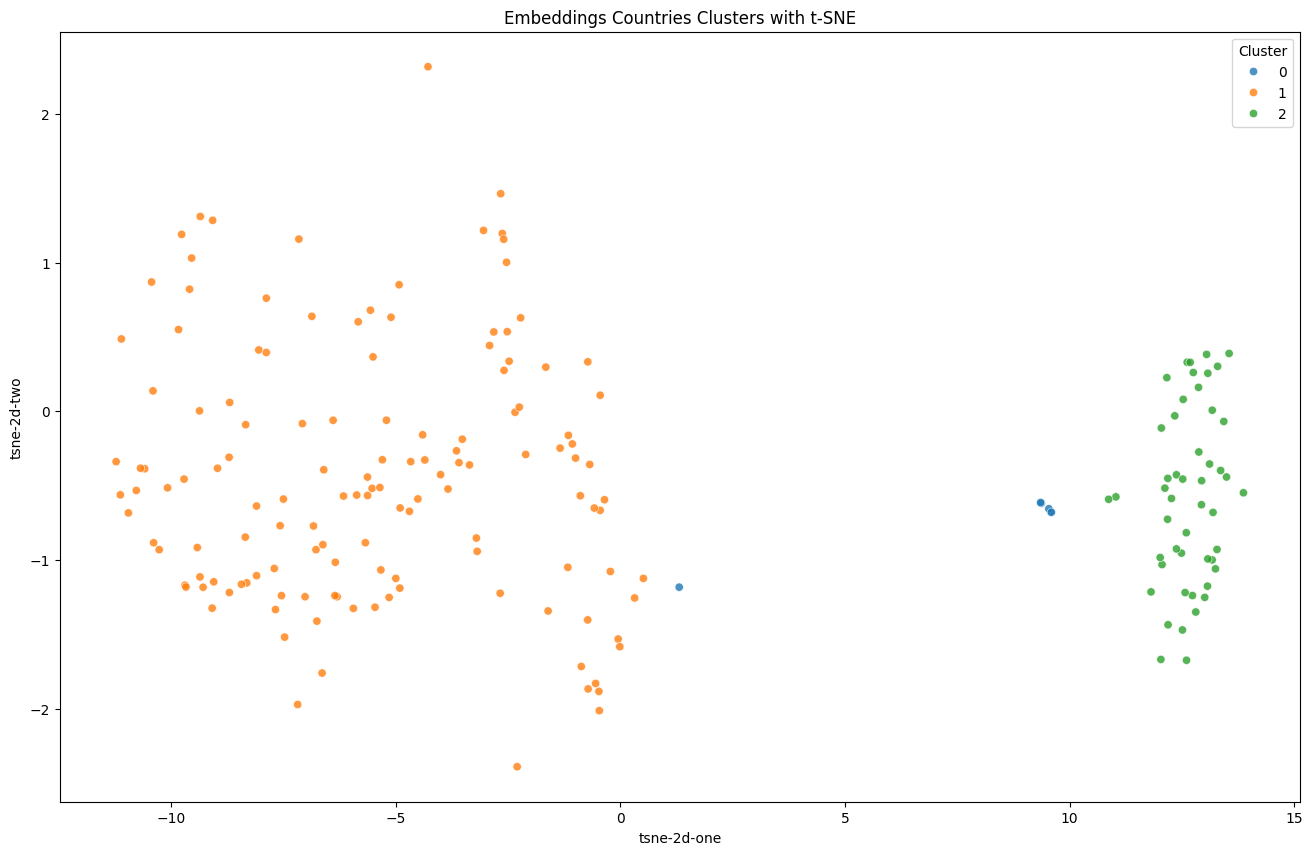

In [24]:
# Call the plotting function
plot_clusters(reduced_dim, clusters, "Embeddings Countries Clusters with t-SNE")

In [31]:
groups = {}

for i in range(dataset.num_countries):
    label = str(clusterer.labels_[i])
    prob = clusterer.probabilities_[i]

    if(prob > 0.2):

        if(not label in groups):
            groups[label] = []

        country = dataset.country_by_idx[i]
        groups[label].append(country)

In [32]:
print(groups)


{'1': ['AFGHANISTAN', 'ALGERIA', 'ANGOLA', 'ANTIGUA AND BARBUDA', 'ARGENTINA', 'AZERBAIJAN', 'BAHAMAS', 'BAHRAIN', 'BANGLADESH', 'BARBADOS', 'BELARUS', 'BELIZE', 'BENIN', 'BHUTAN', 'BOLIVIA', 'BOTSWANA', 'BRAZIL', 'BRUNEI DARUSSALAM', 'BURKINA FASO', 'BURUNDI', 'CABO VERDE', 'CAMBODIA', 'CAMEROON', 'CENTRAL AFRICAN REPUBLIC', 'CHILE', 'CHINA', 'COLOMBIA', 'COMOROS', 'CONGO', 'COSTA RICA', 'CUBA', "CÔTE D'IVOIRE", 'DJIBOUTI', 'DOMINICA', 'DOMINICAN REPUBLIC', 'ECUADOR', 'EGYPT', 'EL SALVADOR', 'EQUATORIAL GUINEA', 'ERITREA', 'ESWATINI', 'ETHIOPIA', 'FIJI', 'GABON', 'GAMBIA', 'GHANA', 'GRENADA', 'GUATEMALA', 'GUINEA', 'GUINEA-BISSAU', 'GUYANA', 'HAITI', 'HONDURAS', 'INDIA', 'INDONESIA', 'IRAN (ISLAMIC REPUBLIC OF)', 'IRAQ', 'JAMAICA', 'JORDAN', 'KAZAKHSTAN', 'KENYA', 'KUWAIT', 'KYRGYZSTAN', "LAO PEOPLE'S DEMOCRATIC REPUBLIC", 'LEBANON', 'LESOTHO', 'LIBERIA', 'LIBYA', 'MADAGASCAR', 'MALAWI', 'MALAYSIA', 'MALDIVES', 'MALI', 'MAURITANIA', 'MAURITIUS', 'MEXICO', 'MONGOLIA', 'MOROCCO', 'MOZAM

In [33]:
countries = set()

# Extract unique countries
for resolution in resolutions:
    for country, vote in  resolution['Vote'].items():
        if(not country in countries):
            countries.add(country)

countries = list(countries)
countries

['CHAD',
 'MAURITIUS',
 'LESOTHO',
 'BRUNEI DARUSSALAM',
 'HONDURAS',
 'ROMANIA',
 'OMAN',
 'LIBERIA',
 'NORWAY',
 'GUYANA',
 'SAO TOME AND PRINCIPE',
 'QATAR',
 'INDIA',
 'GHANA',
 'GUINEA-BISSAU',
 'UNITED STATES',
 'BELARUS',
 "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA",
 'NIGER',
 'UNITED REPUBLIC OF TANZANIA',
 'DOMINICAN REPUBLIC',
 'SOMALIA',
 'SPAIN',
 'SAMOA',
 'IRAN (ISLAMIC REPUBLIC OF)',
 'ALBANIA',
 'THAILAND',
 'CHILE',
 'TURKMENISTAN',
 'CAMEROON',
 'PAKISTAN',
 'SOUTH SUDAN',
 'BELGIUM',
 'JORDAN',
 'KAZAKHSTAN',
 'PALAU',
 'CANADA',
 'ETHIOPIA',
 'DOMINICA',
 'HUNGARY',
 'CAMBODIA',
 'INDONESIA',
 'SAUDI ARABIA',
 'SWITZERLAND',
 'TOGO',
 'UZBEKISTAN',
 'LIBYA',
 'ESTONIA',
 'PHILIPPINES',
 'TAJIKISTAN',
 'SENEGAL',
 'DENMARK',
 'SRI LANKA',
 'GUINEA',
 'CABO VERDE',
 'TÜRKİYE',
 'NEW ZEALAND',
 'ARGENTINA',
 'BHUTAN',
 'BOSNIA AND HERZEGOVINA',
 'SOLOMON ISLANDS',
 'MALAWI',
 'ESWATINI',
 'SLOVAKIA',
 'ANTIGUA AND BARBUDA',
 'YEMEN',
 'FRANCE',
 'GUATEMALA',
 'BOLIVIA',
 

Node2Vec Algorithm

In [34]:
# Create a graph
G = nx.Graph()
for country in countries:
    G.add_node(country)

def calculate_voting_similarity(country1, country2):
    return compare_country(country1, country2)

# Add edges based on similarity
for i, country1 in enumerate(countries):
    for country2 in countries[i+1:]:
        similarity = calculate_voting_similarity(country1, country2)       
        if similarity > 0.6:  # Threshold for similarity
            G.add_edge(country1, country2, weight=similarity)

In [35]:
# Apply Node2Vec
# Best score: (0.85948616, 3)
# Best parameters: (128, 10, 50, 5)
# best_params = (dimensions, walk_length, num_walks, window)
#node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec = Node2Vec(G, dimensions=128, walk_length=10, num_walks=50, workers=4)
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 192/192 [00:25<00:00,  7.61it/s]


In [36]:
# Get embeddings
n2v_embeddings = [n2v_model.wv[str(node)] for node in G.nodes()]

In [37]:
display_pca_scatterplot_3D(n2v_embeddings)

In [38]:
# Apply PCA to reduce dimensions
n2v_pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
n2v_reduced_embeddings = n2v_pca.fit_transform(n2v_embeddings)

# Cluster the embeddings
n2v_kmeans = KMeans(n_clusters=3)
n2v_clusters = kmeans.fit_predict(n2v_reduced_embeddings)

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [39]:
# Creating a dictionary to store countries in each cluster
clustered_countries = {i: [] for i in range(kmeans.n_clusters)}

# Assigning countries to clusters
for country, cluster in zip(G.nodes(), n2v_clusters):
    clustered_countries[cluster].append(country)

for cluster, countries in clustered_countries.items():
    print(f"Cluster {cluster}: {', '.join(countries)}")

Cluster 0: CHAD, MAURITIUS, LESOTHO, BRUNEI DARUSSALAM, HONDURAS, OMAN, LIBERIA, GUYANA, SAO TOME AND PRINCIPE, QATAR, INDIA, GHANA, GUINEA-BISSAU, BELARUS, DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA, NIGER, UNITED REPUBLIC OF TANZANIA, DOMINICAN REPUBLIC, SOMALIA, SAMOA, IRAN (ISLAMIC REPUBLIC OF), THAILAND, CHILE, TURKMENISTAN, CAMEROON, PAKISTAN, SOUTH SUDAN, JORDAN, KAZAKHSTAN, ETHIOPIA, DOMINICA, CAMBODIA, INDONESIA, SAUDI ARABIA, TOGO, UZBEKISTAN, LIBYA, PHILIPPINES, TAJIKISTAN, SENEGAL, SRI LANKA, GUINEA, CABO VERDE, ARGENTINA, BHUTAN, SOLOMON ISLANDS, MALAWI, ESWATINI, ANTIGUA AND BARBUDA, YEMEN, GUATEMALA, BOLIVIA, EQUATORIAL GUINEA, ZAMBIA, CENTRAL AFRICAN REPUBLIC, ERITREA, BANGLADESH, BOTSWANA, MONGOLIA, TONGA, CONGO, CUBA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, NIGERIA, VENEZUELA, BURKINA FASO, COLOMBIA, SAINT LUCIA, GAMBIA, KIRIBATI, JAMAICA, PERU, UGANDA, FIJI, MAURITANIA, IRAQ, UNITED ARAB EMIRATES, DEMOCRATIC REPUBLIC OF THE CONGO, EGYPT, BRAZIL, BAHAMAS, MALDIVES, AZERBAIJAN, L

In [40]:
# Evaluate clustering
n2v_score = silhouette_score(n2v_embeddings, n2v_clusters)

# Calculating Davies-Bouldin Index
n2v_dbi = davies_bouldin_score(n2v_embeddings, n2v_clusters)

print(n2v_score)
print(n2v_dbi)

0.8307374
0.2916446740985794


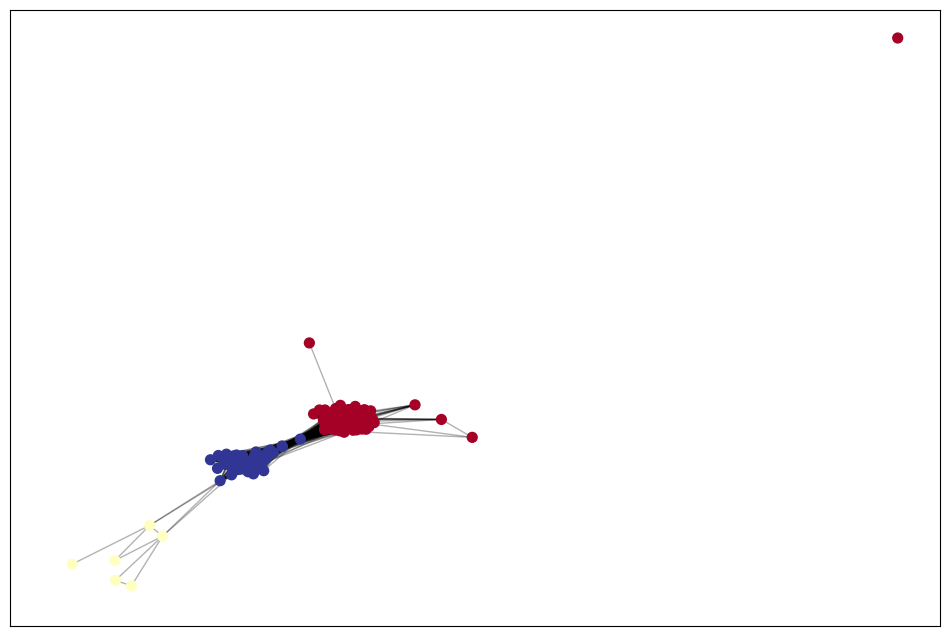

In [41]:
import matplotlib.pyplot as plt

# Plotting
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=n2v_clusters)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show()

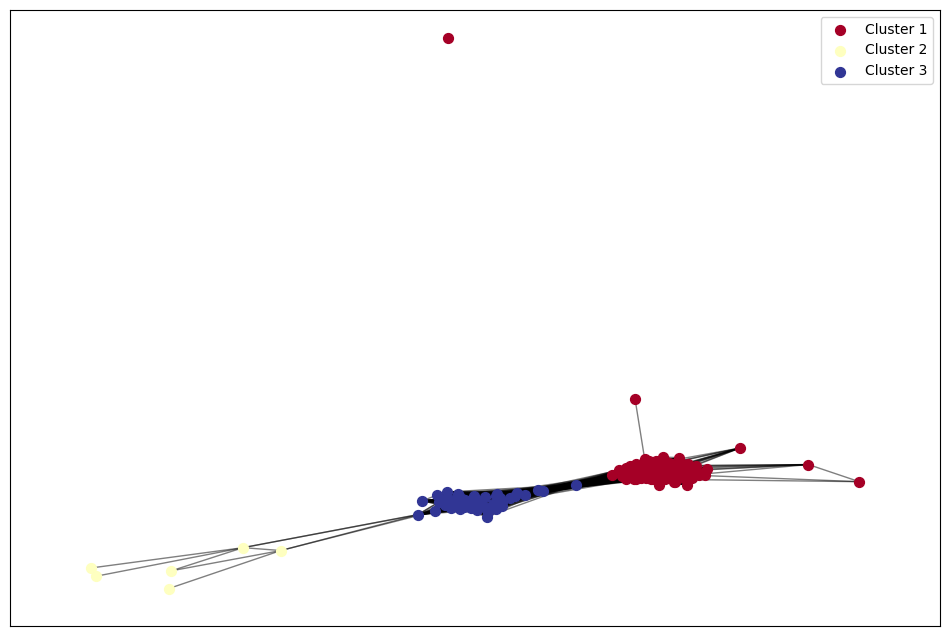

In [42]:
# Plotting with legends
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

# Draw nodes and assign colors based on cluster
for i in range(max(n2v_clusters) + 1):
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=[node for node, cluster in zip(G.nodes(), n2v_clusters) if cluster == i],
                           node_color=[plt.cm.RdYlBu(i / max(n2v_clusters))],
                           label=f'Cluster {i + 1}',
                           node_size=50)

nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add legend and show the plot
plt.legend()
plt.show()

In [43]:
import plotly.graph_objects as go
import plotly.express as px

# Create Plotly figure
fig = go.Figure()

# Add nodes as scatter plot
for i, (embedding, country) in enumerate(zip(n2v_reduced_embeddings, G.nodes())):
    fig.add_trace(go.Scatter(
        x=[embedding[0]], 
        y=[embedding[1]], 
        mode='markers+text',
        text=country,
        textposition='top center',
        marker=dict(color=px.colors.qualitative.Plotly[n2v_clusters[i]], size=10),
        name=f'{country}'
    ))

# Update layout
fig.update_layout(
    title='UN General Assembly Voting Patterns',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    showlegend=True
)

# Show the figure
fig.show()

Hyperparameter tunning.

In [39]:
def evaluate_model(embeddings):
    """
    Evaluates the embeddings based on the Silhouette Score.
    
    :param embeddings: The embeddings to be evaluated.
    :return: Silhouette Score.
    """
    # Assuming we don't know the best number of clusters beforehand
    best_score = -1
    best_k = 2

    # Trying different numbers of clusters
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)

        if score > best_score:
            best_score = score
            best_k = k

    return best_score, best_k

In [96]:
# Hyperparameter grid
param_grid = {
    'dimensions': [32, 64, 128],
    'walk_length': [10, 20, 30],
    'num_walks': [50, 100, 200],
    'window': [5, 10, 15]
}

# Grid search
best_score = None
best_params = None

for dimensions, walk_length, num_walks, window in itertools.product(*param_grid.values()):
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks)
    n2vmodel = node2vec.fit(window=window)
    embeddings = [n2vmodel.wv[str(node)] for node in G.nodes()]
    
    score = evaluate_model(embeddings)
    
    if best_score is None or score > best_score:
        best_score = score
        best_params = (dimensions, walk_length, num_walks, window)

print("Best score:", best_score)
print("Best parameters:", best_params)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:01<00:00, 25.38it/s]
C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Best score: (0.85948616, 3)
Best parameters: (128, 10, 50, 5)


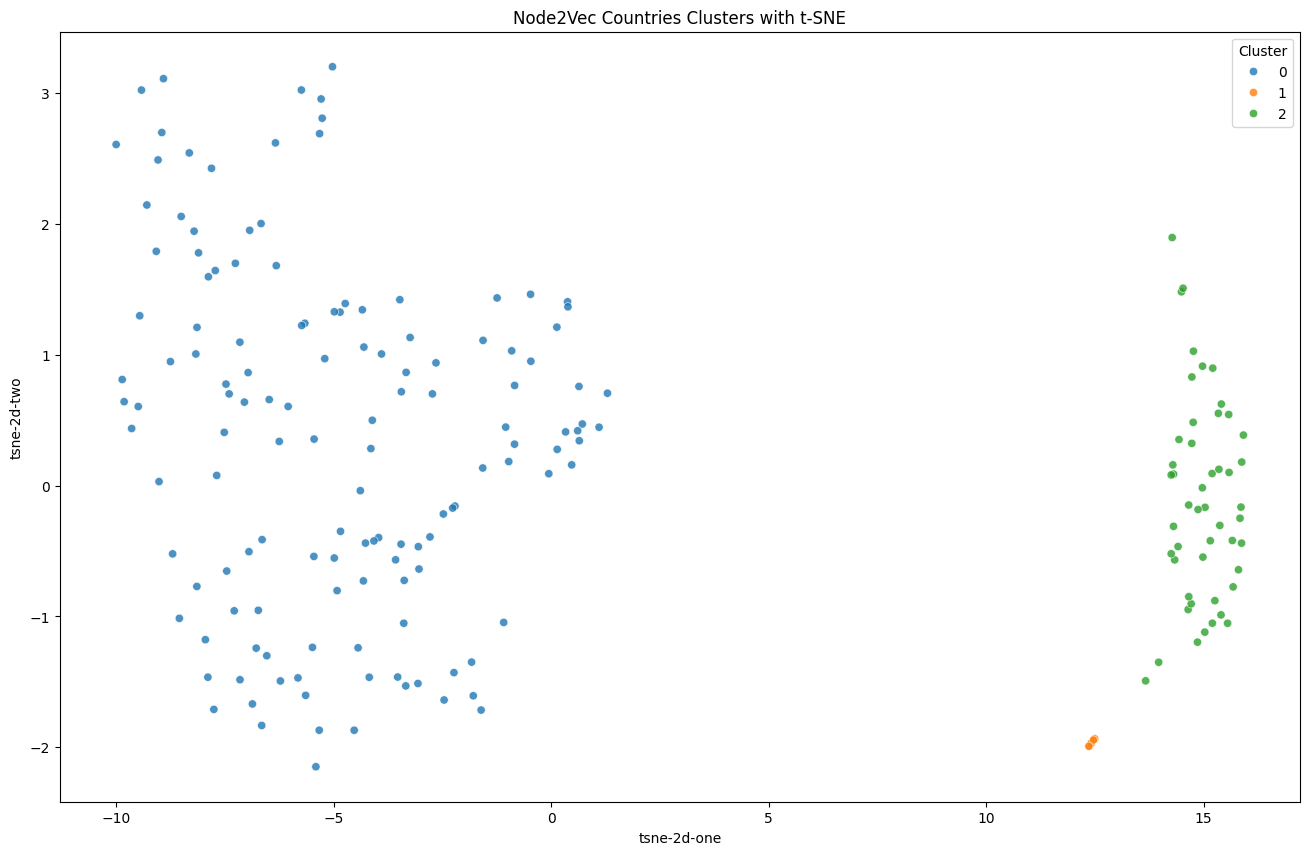

In [44]:
# Call the plotting function
plot_clusters(n2v_reduced_embeddings, n2v_clusters, "Node2Vec Countries Clusters with t-SNE")

Graph Autoencoders (GAE)

In [45]:
# Load the dataset

file_path = './un_general_assembly_votes.csv'
votes_data  = pd.read_csv(file_path)
votes_data.head()

id                                              Title  \
0  4003689  Cooperation between the United Nations and the...   
1  4003921  Principles of the Charter of the United Nation...   
2  4009707  Cooperation between the United Nations and the...   
3  4014141  Independent Institution on Missing Persons in ...   
4  4014142  Financing of the United Nations Interim Force ...   

                                              Agenda     Resolution  \
0  A/77/251 127n Cooperation between the United N...   A/RES/77/272   
1  A/ES-11/2 5 Letter dated 28 February 2014 from...  A/RES/ES-11/6   
2  A/77/251 127l Cooperation between the United N...   A/RES/77/284   
3  A/77/251 13 Integrated and coordinated impleme...   A/RES/77/301   
4  A/77/251 163b United Nations Interim Force in ...   A/RES/77/313   

  Meeting record Draft resolution                                  Note  \
0     A/77/PV.59  A/77/L.49/Rev.1  RECORDED - No machine generated vote   
1  A/ES-11/PV.19              NaN  RECORDED - No machine generated vote   
2     A/77/PV.69        A/77/L.65  RECORDED - No machine generated vote   
3     A/77/PV.85        A/77/L.79  RECORDED - No machine generated vote   
4     A/77/PV.87    A/C.5/77/L.38  RECORDED - No machine generated vote   

                                        Vote summary   Vote date  \
0  Voting Summary Yes: 112 | No: 7 | Abstentions:...  2023-02-20   
1  Voting Summary Yes: 141 | No: 7 | Abstentions:...  2023-02-23   
2  Voting Summary Yes: 122 | No: 5 | Abstentions:...  2023-04-26   
3  Voting Summary Yes: 83 | No: 11 | Abstentions:...  2023-06-29   
4  Voting Summary Yes: 120 | No: 3 | Abstentions:...  2023-06-30   

                                                Vote  \
0  {'AFGHANISTAN': '', 'ALBANIA': 'Y', 'ALGERIA':...   
1  {'AFGHANISTAN': 'Y', 'ALBANIA': 'Y', 'ALGERIA'...   
2  {'AFGHANISTAN': '', 'ALBANIA': 'Y', 'ALGERIA':...   
3  {'AFGHANISTAN': '', 'ALBANIA': 'Y', 'ALGERIA':...   
4  {'AFGHANISTAN': '', 'ALBANIA': 'Y', 'ALGERIA':...   

                                         Collections Committee report  
0  UN Bodies > General Assembly > General Assembl...              NaN  
1  UN Bodies > General Assembly > General Assembl...              NaN  
2  UN Bodies > General Assembly > General Assembl...              NaN  
3  UN Bodies > General Assembly > General Assembl...              NaN  
4  UN Bodies > General Assembly > General Assembl...         A/77/932

In [46]:
# Extract voting data and preprocess
# Assuming 'Vote' column contains dictionaries of country votes
votes = votes_data['Vote'].apply(eval)  # Convert string representation of dict to actual dict
votes_df = pd.DataFrame(votes.tolist())  # Convert list of dicts to DataFrame

In [47]:
# One-hot encode the votes (Yes, No, Abstain, No Vote)
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_votes = encoder.fit_transform(votes_df.fillna('No Vote'))

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [48]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(encoded_votes)

In [49]:
# Create a graph from the similarity matrix
graph = nx.from_numpy_matrix(similarity_matrix)

In [50]:
# Feature matrix (X) and adjacency matrix (A) for the GAE
X = np.eye(G.number_of_nodes())
A = nx.adjacency_matrix(G).toarray()

# Ensure X and A have compatible first dimensions
assert X.shape[0] == A.shape[0]

C:\Users\patfernandes\AppData\Local\Temp\ipykernel_8348\2060568918.py:3: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



In [51]:
# Graph Autoencoder Architecture
def graph_autoencoder(features_shape, adjacency_shape):
    # Encoder
    input_feat = Input(shape=(features_shape,))
    
    x = Dense(64, activation='relu')(input_feat)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)  # This layer produces the embeddings
    
    # Decoder
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    reconstructed_adj = Dense(adjacency_shape, activation='sigmoid')(x)
    
    model = Model(inputs=input_feat, outputs=reconstructed_adj)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    return model

In [52]:
# Instantiate and train the GAE
gae = graph_autoencoder(features_shape=X.shape[1], adjacency_shape=A.shape[0])
gae.fit(X, A, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 2s 3ms/step - loss: 0.6920
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6894
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6856
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6802
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6728
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6604
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6445
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6266
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6079
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5974
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5911
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5841
Epoch 13/100
6/6 [==============================] - 0s 3ms/st

In [53]:
# Extract embeddings for clustering
encoder = Model(inputs=gae.input, outputs=gae.layers[4].output)
gae_embeddings = encoder.predict(X)

6/6 [==============================] - 0s 2ms/step


In [54]:
# Apply clustering on the embeddings
gae_kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
gae_clusters = gae_kmeans.fit_predict(gae_embeddings)

C:\Users\patfernandes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



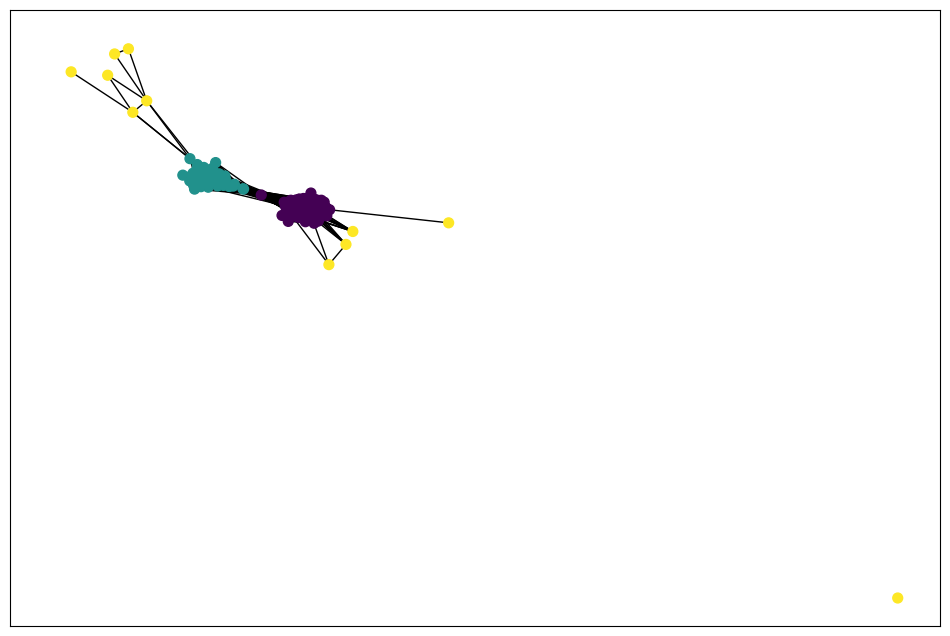

In [55]:
# Visualization (optional)
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, node_color=gae_clusters, node_size=50, with_labels=False)
plt.show()


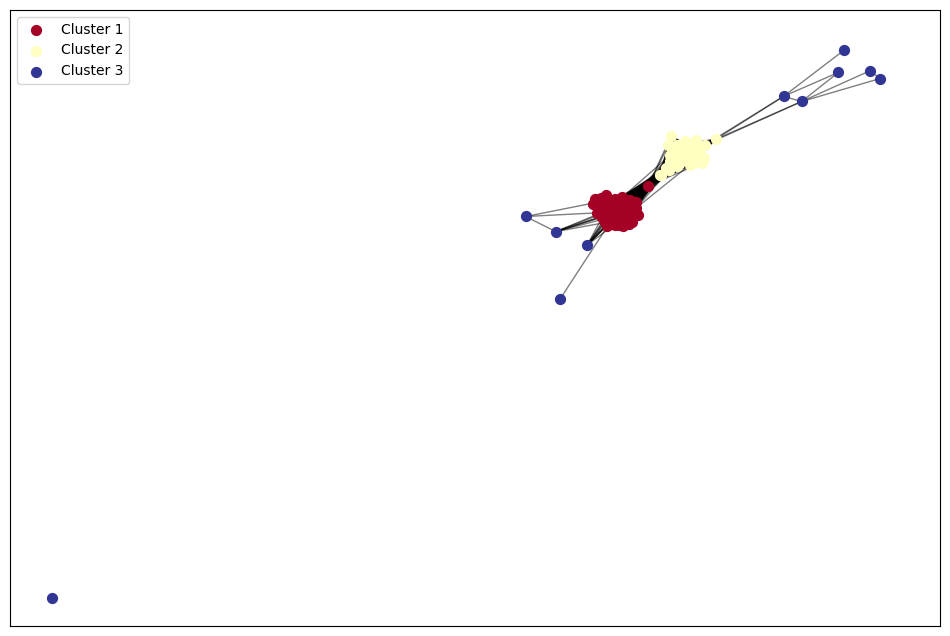

In [56]:
# Plotting with legends
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

# Draw nodes and assign colors based on cluster
for i in range(max(gae_clusters) + 1):
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=[node for node, cluster in zip(G.nodes(), gae_clusters) if cluster == i],
                           node_color=[plt.cm.RdYlBu(i / max(gae_clusters))],
                           label=f'Cluster {i + 1}',
                           node_size=50)

nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add legend and show the plot
plt.legend()
plt.show()

In [57]:
# Evaluate clustering
gae_score = silhouette_score(gae_embeddings, gae_clusters)

# Calculating Davies-Bouldin Index
gae_dbi = davies_bouldin_score(gae_embeddings, gae_clusters)

print(gae_score)
print(gae_dbi)

0.7015104
0.4445195104159066


In [58]:
# Apply PCA to reduce dimensions
gae_pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
gae_reduced_embeddings = gae_pca.fit_transform(gae_embeddings)

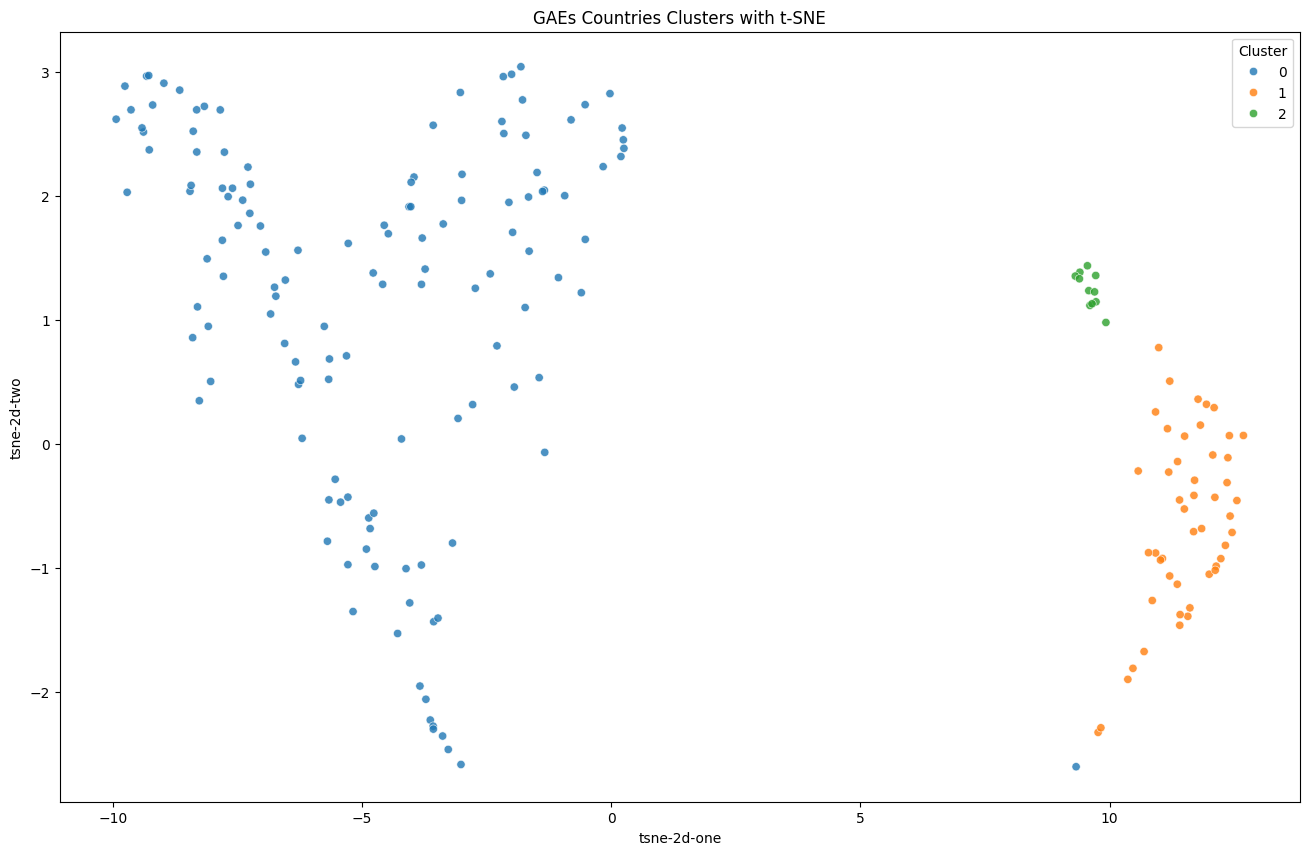

In [59]:
# Call the plotting function
plot_clusters(gae_reduced_embeddings, gae_clusters, "GAEs Countries Clusters with t-SNE")